In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

In [3]:
batch_size = 100
img_height = 250
img_width = 250

In [6]:
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data/train',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/accident-detection-from-cctv-footage/data/test',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size)

validation_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/accident-detection-from-cctv-footage/data/val',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size)

Found 791 files belonging to 2 classes.


NotFoundError: Could not find directory /kaggle/input/accident-detection-from-cctv-footage/data/test

In [5]:
class_names = training_ds.class_names

## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
testing_ds = testing_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
from keras.applications.vgg16 import VGG16

In [7]:
img_shape = (img_height, img_width, 3)

base_model = tf.keras.applications.VGG16(input_shape=img_shape,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [8]:
model = tf.keras.Sequential([
    base_model,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(128, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(len(class_names), activation= 'softmax')
])

In [9]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
history = model.fit(training_ds, validation_data = validation_ds, epochs = 50)

Epoch 1/50
8/8 [==============================] - 319s 40s/step - loss: 2.7945 - accuracy: 0.5803 - val_loss: 0.7810 - val_accuracy: 0.5510
Epoch 2/50
8/8 [==============================] - 313s 40s/step - loss: 0.4968 - accuracy: 0.7800 - val_loss: 0.4294 - val_accuracy: 0.8061
Epoch 3/50
8/8 [==============================] - 318s 40s/step - loss: 0.2756 - accuracy: 0.9064 - val_loss: 0.2800 - val_accuracy: 0.9184
Epoch 4/50
8/8 [==============================] - 319s 41s/step - loss: 0.1554 - accuracy: 0.9507 - val_loss: 0.2096 - val_accuracy: 0.9286
Epoch 5/50
8/8 [==============================] - 315s 40s/step - loss: 0.0812 - accuracy: 0.9760 - val_loss: 0.1599 - val_accuracy: 0.9388
Epoch 6/50
8/8 [==============================] - 313s 40s/step - loss: 0.0585 - accuracy: 0.9785 - val_loss: 0.1428 - val_accuracy: 0.9184
Epoch 7/50
8/8 [==============================] - 312s 40s/step - loss: 0.0385 - accuracy: 0.9861 - val_loss: 0.1656 - val_accuracy: 0.9286
Epoch 8/50
8/8 [====

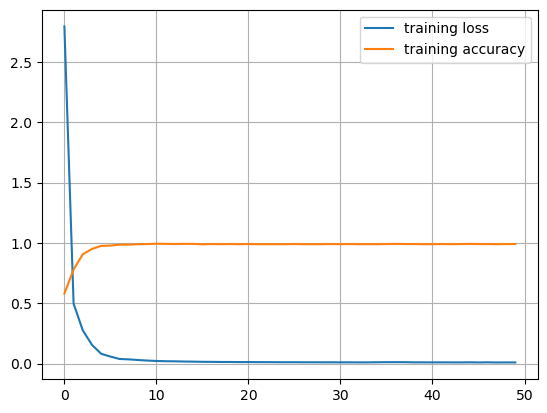

In [11]:
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()

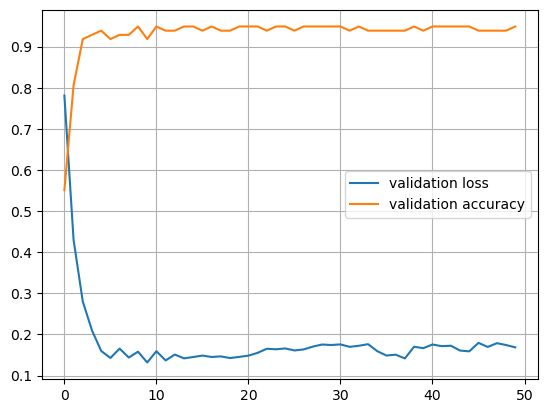

In [12]:
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.grid(True)
plt.legend()

4/4 [==============================] - 35s 8s/step


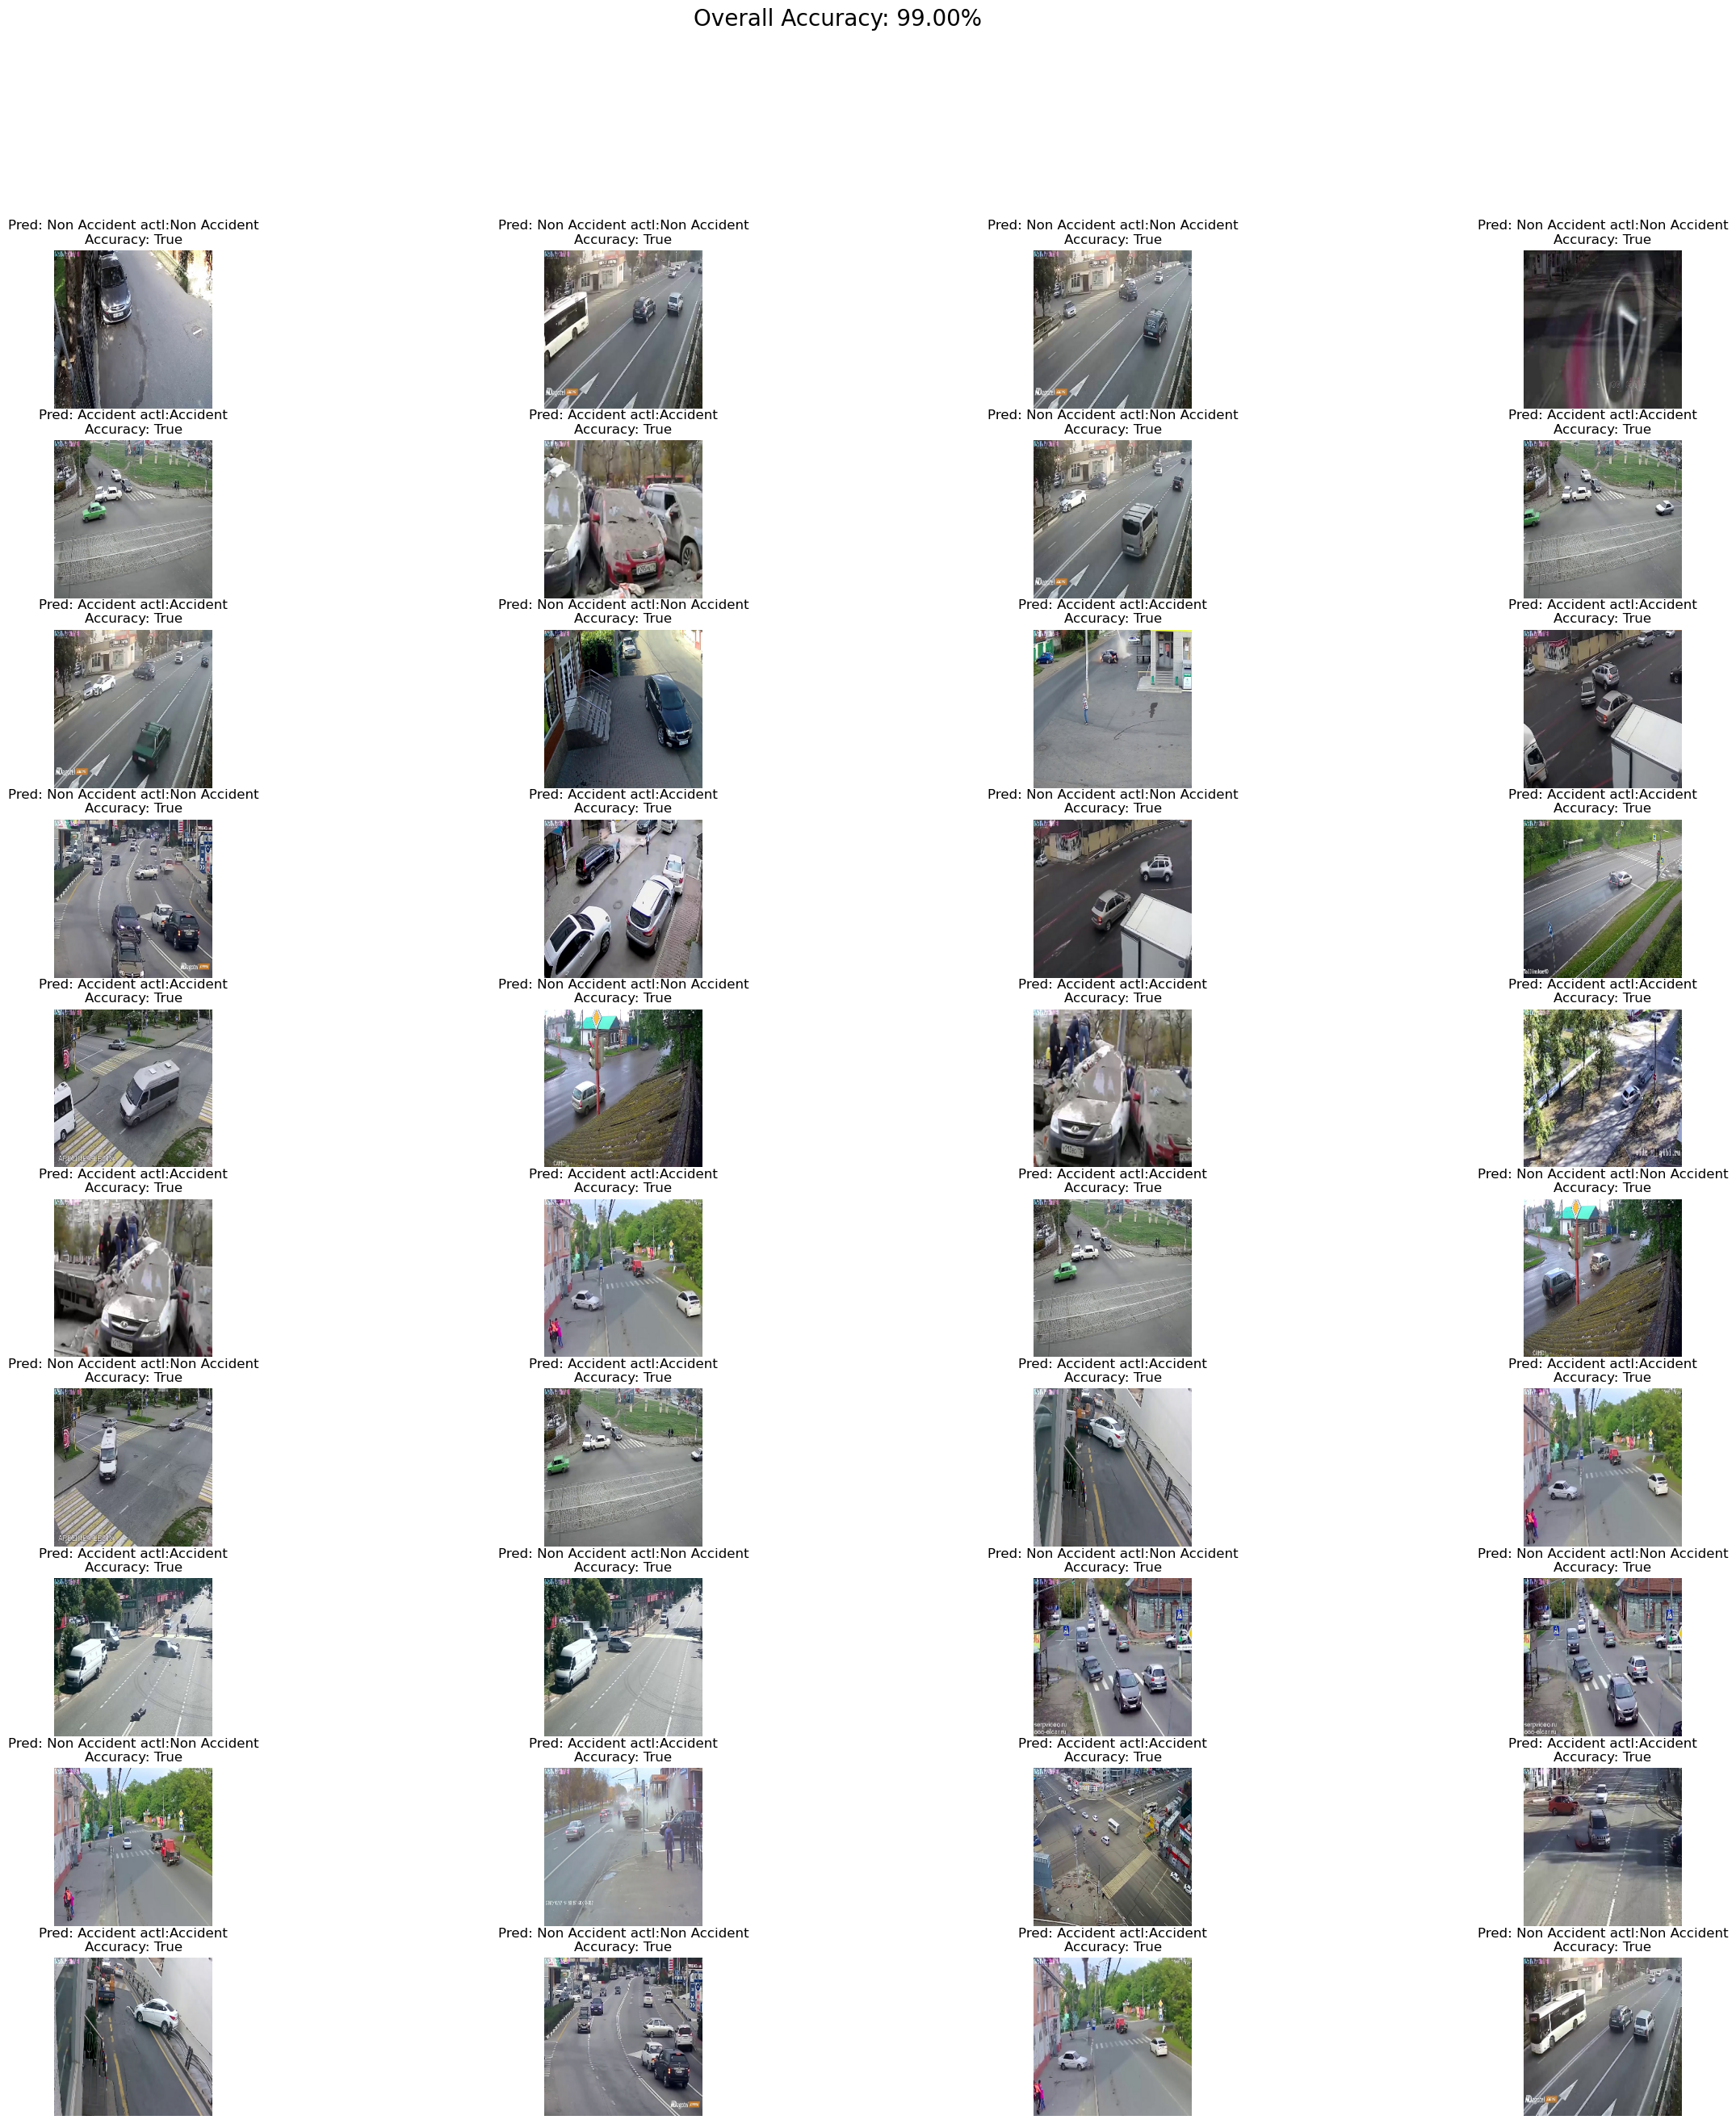

In [13]:
AccuracyVector = []

plt.figure(figsize=(30, 30))
for images, labels in testing_ds.take(1):
    predictions = model.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels
    
    # Calculate accuracy
    accuracy = np.mean(AccuracyVector)
    
    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # Display predicted and actual labels along with accuracy
        plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] + f'\nAccuracy: {AccuracyVector[i]}')
        
        plt.axis('off')
        plt.grid(True)

# Display overall accuracy
plt.suptitle(f'Overall Accuracy: {accuracy:.2%}', fontsize=20)
plt.show()

In [14]:
# Confusion Matrix

truePositive=0
trueNegative=0
falsePositive=0
falseNegative=0
#positive event is accident negative event is non accident
for i in range(0,100):
    if(predlabel[i]==class_names[labels[i]] and predlabel[i]=='Accident'):
        truePositive+=1
    elif(predlabel[i]==class_names[labels[i]] and predlabel[i]=='Non Accident'):
        trueNegative+=1
    elif(predlabel[i]=='Non Accident' and class_names[labels[i]]=='Accident'):
        falseNegative+=1
    else:
        falsePositive+=1

In [15]:
print(f'True positives are: {truePositive}')
print(f'True negatives are: {trueNegative}')
print(f'False negatives are: {falseNegative}')
print(f'False positives are: {falsePositive}')

True positives are: 46
True negatives are: 53
False negatives are: 1
False positives are: 0


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


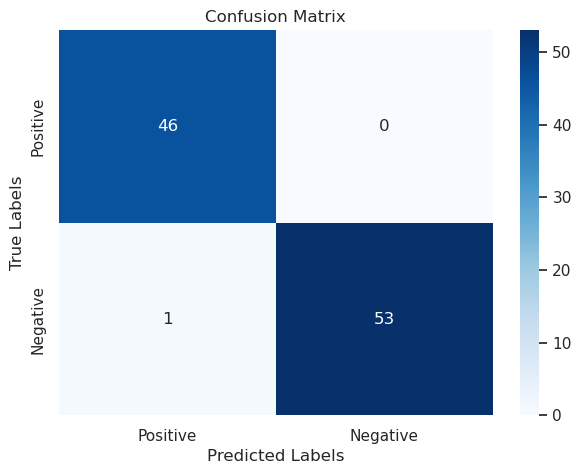

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

true_positives = 46
true_negatives = 53
false_negatives = 1
false_positives = 0

confusion_mat = confusion_matrix([1, 0, 1, 0], [1, 0, 0, 1],
                                  labels=[1, 0],
                                  sample_weight=[true_positives, true_negatives, false_positives, false_negatives])

labels = ['Positive', 'Negative']

sns.set()
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

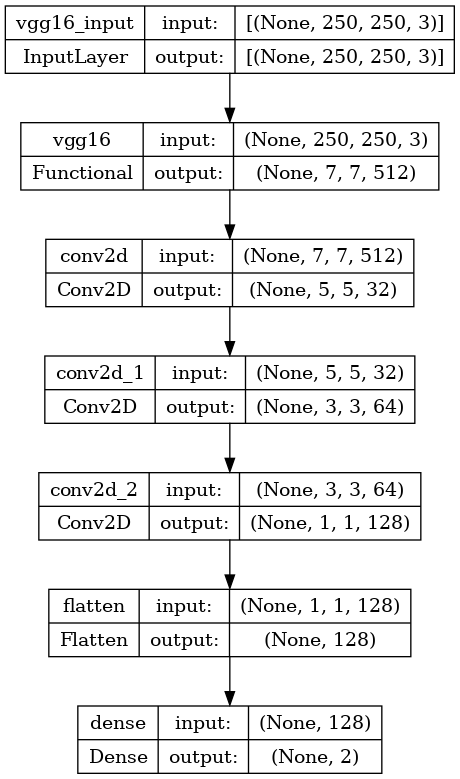

In [18]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [19]:
print(class_names)

['Accident', 'Non Accident']


In [20]:
def predict_frame(img):
    img_array = tf.keras.utils.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    prediction=(model.predict(img_batch) > 0.5).astype("int32")
    if(prediction[0][0]==0):
        return("Accident Detected")
    else:
        return("No Accident")

In [21]:
import cv2
image=[]
label=[]

c=1
cap= cv2.VideoCapture('/kaggle/input/cctvfootagevideo/videoplayback (online-video-cutter.com).mp4')
while True:
    grabbed, frame = cap.read()
    if c%30==0:
        print(c)
        resized_frame=tf.keras.preprocessing.image.smart_resize(frame, (img_height, img_width), interpolation='bilinear')
        image.append(frame)
        label.append(predict_frame(resized_frame))
        if(len(image)==75):
            break
    c+=1

cap.release()

30
1/1 [==============================] - 0s 376ms/step
60
1/1 [==============================] - 0s 368ms/step
90
1/1 [==============================] - 0s 376ms/step
120
1/1 [==============================] - 0s 369ms/step
150
1/1 [==============================] - 0s 367ms/step
180
1/1 [==============================] - 0s 364ms/step
210
1/1 [==============================] - 0s 371ms/step
240
1/1 [==============================] - 0s 369ms/step
270
1/1 [==============================] - 0s 364ms/step
300
1/1 [==============================] - 0s 380ms/step
330
1/1 [==============================] - 0s 364ms/step
360
1/1 [==============================] - 0s 369ms/step
390
1/1 [==============================] - 0s 368ms/step
420
1/1 [==============================] - 0s 371ms/step
450
1/1 [==============================] - 0s 366ms/step
480
1/1 [==============================] - 0s 375ms/step
510
1/1 [==============================] - 0s 367ms/step
540
1/1 [=========================

No Accident
AxesImage(size=(360, 640))


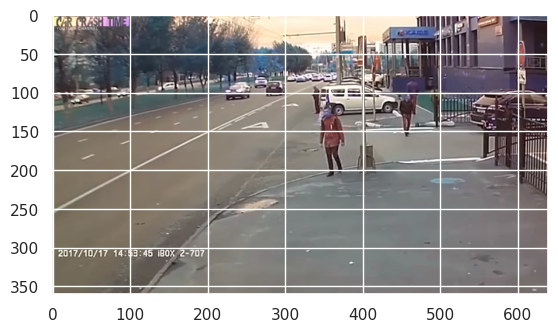

In [24]:
print(label[20])
print(plt.imshow(image[20]))

In [25]:
model.save('model.h5')